# Multi-scale Low Rank Decomposition Demo

## Introduction

Multi-scale signal transforms are commonplace in signal analysis, engineering. Commonly known examples include wavelet pyramids, and discrete cosine transform, used for image compression. The utility of such representations lies in their ability to **compactly represent natural signals**. MRI Imaging also takes advantage of this property. 

![mslrd2.png](mslrd2.png "Illutration of Multi-scale Representation")

Similarly, low rank models provide a means for **subspace estimation**. Recall that a matrix is low-rank when it can be expressed by a (relatively) small number of basis vectors. 
Essentially, a low rank matrix possesses **redundancy**. This proves useful in tasks that are essentially matrix completion problems. 
If you can say with reasonable confidence that your target data with 'holes' or unknown values is low rank, then low-rank models can help estimate them reliably and often quite accurately. 

In the paper *Beyond Low Rank + Sparse: Multi-scale Low Rank Matrix Decomposition* [1], the authors introduce a matrix decomposition method that capitalizes on multi-scale structures and low rank methods.

### Why combine the two?

The argument for utilizing multi-scale representation in conjunuction with low rank modeling is quite simple. Signals often exhibit multi-scale structure. Therefore, you can capture correlation at more than one scale, and represent it more compactly, with more granularity than a low rank model for the whole signal. The paper proposes modeling the target data matrix as a sum of block matrices of increasing sizes, with each set of blocks of equal size comprising a scale. 


## An illustration of low rank data

In [1]:
import numpy as np
from multiprocessing import Pool
import numpy.matlib as npm
import matplotlib.pyplot as plt
import cv2
from blockSVT import blockSVT
from liveplot import liveplot
from skimage.transform import resize
from skimage.metrics import peak_signal_noise_ratio, mean_squared_error
from randshift import *
from gen_hanning import gen_hanning
from sklearn.preprocessing import normalize

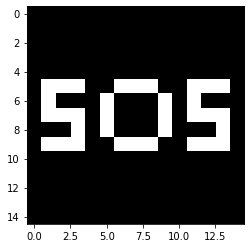

In [2]:
sos = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0],
          [0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0],
          [0, 1, 1, 1, 0, 1, 0, 0 ,0, 1, 0, 1, 1, 1, 0],
          [0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0],
          [0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
plt.imshow(sos, cmap='gray')

This very simple image has $9$ rows, of which only $5$ are populated, so the rank will not exceed $5$. Let's plot the singular values of this image.

(Text(0.5, 0, 'component'), Text(0, 0.5, 'Singular Value'))

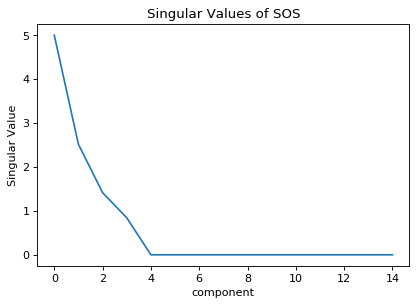

In [3]:
ua, sa, va = np.linalg.svd(sos)
plt.figure(figsize=(6, 4), dpi= 80), plt.plot(range(sos.shape[0]), sa.tolist())
plt.title('Singular Values of SOS')
plt.xlabel('component'), plt.ylabel('Singular Value')

How well can the image be represented if we retain only 3 or 4 of these singular values? 

(<matplotlib.image.AxesImage at 0x7fc2c96cba90>, Text(0.5, 1.0, 'Top-4'))

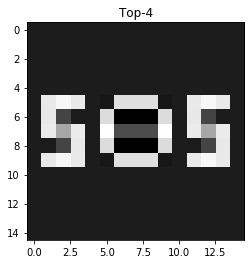

In [4]:
# Keep k=3
sos2 = np.matmul(np.matmul(ua[:,0:3], np.diag(sa[0:3])), va[0:3, :])
plt.imshow(sos2, cmap='gray'), plt.title('Top-4')

(<matplotlib.image.AxesImage at 0x7fc2c963d1d0>, Text(0.5, 1.0, 'Top-3'))

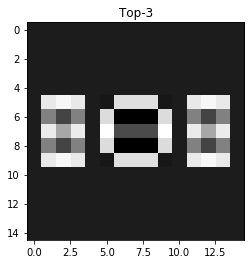

In [5]:
# Keep 2
sos2 = np.matmul(np.matmul(ua[:,0:2], np.diag(sa[0:2])), va[0:2, :])
plt.imshow(sos2, cmap='gray'), plt.title('Top-3')

### What does this mean?
Low rank approximation with the top 4 singular values returns a fairly reasonable recovery of the original image, but crucially, with fewer meaningful values than the original. Beyond a point of course, lower and lower rank approximations will render the recovery unrecognizable from the original image. One utlility of this property is that you could use low rank approximations to recover an image corrupted by noise. 

In [6]:
N = 64
L = np.log2(N)
FOV = (N, N)
max_L = L
block_sizes = 2**np.arange(0, int(max_L+1),2)
ms = block_sizes
ns = ms
block_sizes = [(x, x) for x in block_sizes]
print("Block sizes: ", block_sizes)

Block sizes:  [(1, 1), (4, 4), (16, 16), (64, 64)]


In [7]:
nblocks = np.array([16, 8, 6, 2])
border = np.ones((64, 5))
X, X_decom = gen_hanning(FOV, block_sizes, nblocks, 10)
X_d = np.concatenate([X, border, X_decom[:,:,0], border, X_decom[:,:,1], border, X_decom[:,:,2], border, X_decom[:,:,3]], axis=1)

Text(0.5, 1.0, 'Synthetic image using random Hanning basis vectors with indvidual scales')

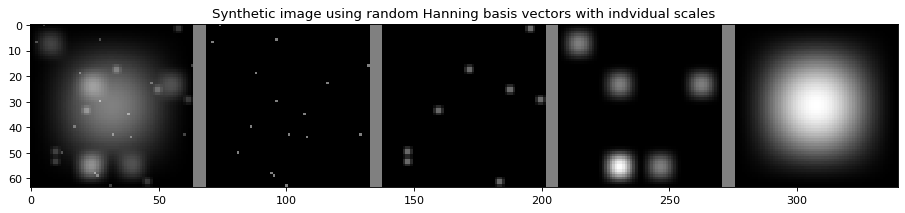

In [8]:
plt.figure(figsize=(14, 12), dpi= 80)
plt.imshow(np.abs(X_d), cmap='gray')
plt.title('Synthetic image using random Hanning basis vectors with indvidual scales')

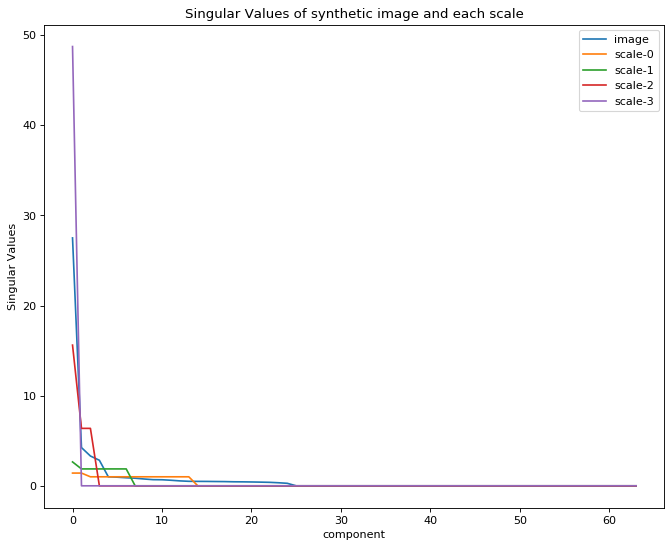

In [18]:
_, sx, _ = np.linalg.svd(X)
_, sx0, _ = np.linalg.svd(X_decom[:,:,0])
_, sx1, _ = np.linalg.svd(X_decom[:,:,1])
_, sx2, _ = np.linalg.svd(X_decom[:,:,2])
_, sx3, _ = np.linalg.svd(X_decom[:,:,3])
plt.figure(figsize=(10, 8), dpi= 80)
plt.plot(range(X.shape[0]), sx.tolist(), label='image')
plt.plot(range(X.shape[0]), sx0.tolist(), label='scale-0')
plt.plot(range(X.shape[0]), sx1.tolist(), label='scale-1')
plt.plot(range(X.shape[0]), sx2.tolist(), label='scale-2')
plt.plot(range(X.shape[0]), sx3.tolist(), label='scale-3')
plt.title('Singular Values of synthetic image and each scale')
plt.xlabel('component'), plt.ylabel('Singular Values')
plt.legend(loc="upper right")

In [10]:
from r_pca import *

rpca = R_pca(X)
L, S = rpca.fit(max_iter=10000, iter_print=100)

iteration: 1, error: 0.07381641243963247
iteration: 100, error: 0.0005536141519379408
iteration: 200, error: 5.60765323187179e-05
iteration: 300, error: 8.30886576896599e-06
iteration: 368, error: 2.8313762040503974e-06


Text(0.5, 1.0, 'Sparse and Low Rank forms from RPCA')

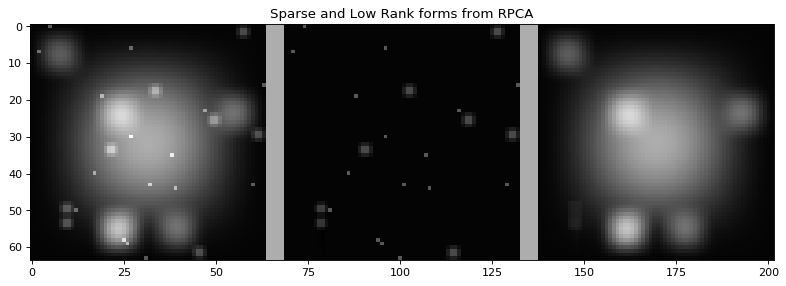

In [11]:
XSL = np.concatenate([X, border, S, border, L], axis=1)
plt.figure(figsize=(12, 10), dpi= 80), plt.imshow(XSL, cmap='gray')
plt.title('Sparse and Low Rank forms from RPCA')

## References



[1] F. Ong and M. Lustig, “Beyond low rank + sparse: Multi-scale low rank matrix decomposition,” 2016 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP), Mar. 2016.